<a href="https://colab.research.google.com/github/sbooeshaghi/azucar/blob/main/analysis/brain/biologics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet leidenalg louvain anndata umap-learn pynndescent session-info scvi-tools
!pip install --quiet --no-deps scanpy

     |████████████████████████████████| 1.3 MB 16.1 MB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
     |████████████████████████████████| 96 kB 5.0 MB/s 
     |████████████████████████████████| 88 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 37.8 MB/s 
     |████████████████████████████████| 3.2 MB 48.8 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 2.0 MB 15.1 MB/s 


In [2]:
!curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/data/brain/rep1/rep.h5ad.gz?raw=true | gunzip > rep1.h5ad
!cat <(curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/data/brain/rep2/rep.h5ad.gz.1?raw=true) \
     <(curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/data/brain/rep2/rep.h5ad.gz.2?raw=true) | gunzip > rep2.h5ad

In [3]:
!curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/reference/brain/celltype/markers.txt?raw=true > markers.txt

In [34]:
import anndata
from scvi.external import CellAssign
import scanpy as sc
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, scale
import glob
from sklearn.mixture import GaussianMixture
import numpy.lib.recfunctions as rf

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
markers = defaultdict(list)
with open("markers.txt", "r") as f:
    for idx, line in enumerate(f.readlines()):
        ct_id, gene_ids = line.strip().split("\t")
        markers[ct_id] = [i for i in gene_ids.split(",")]

In [6]:
df = pd.concat([pd.Series(v, name=k).astype(str) for k, v in markers.items()], 
               axis=1)
df = pd.get_dummies(df.stack()).sum(level=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
r1 = anndata.read_h5ad("rep1.h5ad")
r1.layers["raw"] = r1.X
r1.var.index = r1.var["gene_name"].astype(str) + "_" + r1.var.index.astype(str)

r2 = anndata.read_h5ad("rep2.h5ad")
r2.layers["raw"] = r2.X
r2.var.index = r2.var["gene_name"].astype(str) + "_" + r2.var.index.astype(str)

In [38]:
r1.obs["size_factor"] = r1.layers["raw"].sum(1) / r1.layers["raw"].sum(1).mean()
r2.obs["size_factor"] = r2.layers["raw"].sum(1) / r2.layers["raw"].sum(1).mean()

In [39]:
print(f"Replicate 1: {r1.shape}")
print(f"Replicate 2: {r2.shape}")

Replicate 1: (13221, 55416)
Replicate 2: (50394, 55416)


# Standard QC

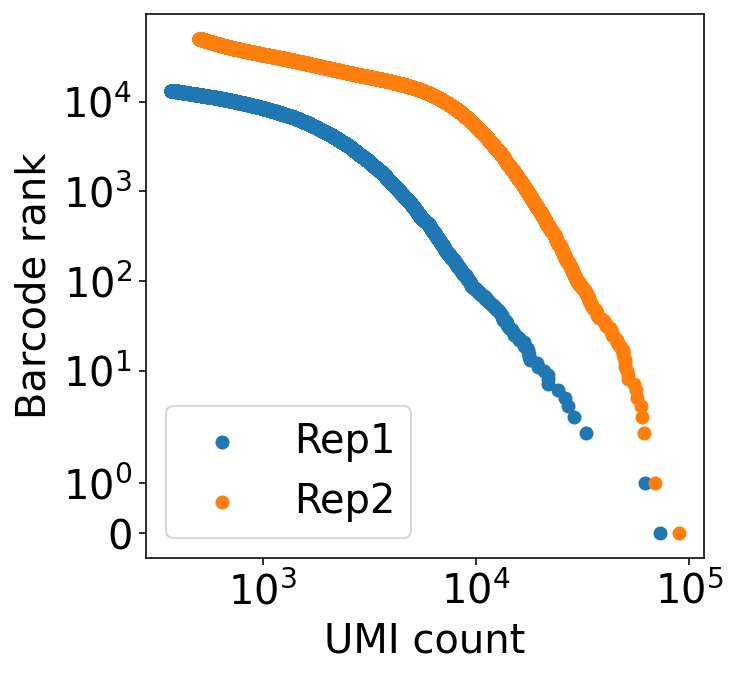

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

data = r1
label = "Rep1"
x = np.sort(nd(data.X.sum(1)))[::-1]
y = np.arange(data.shape[0])

ax.scatter(x,y, label=label)

data = r2
label = "Rep2"
x = np.sort(nd(data.X.sum(1)))[::-1]
y = np.arange(data.shape[0])

ax.scatter(x,y, label=label)

ax.set(**{
    "xlabel": "UMI count",
    "ylabel": "Barcode rank",
    "xscale": "symlog",
    "yscale": "symlog"
})

ax.legend()

fig.show()

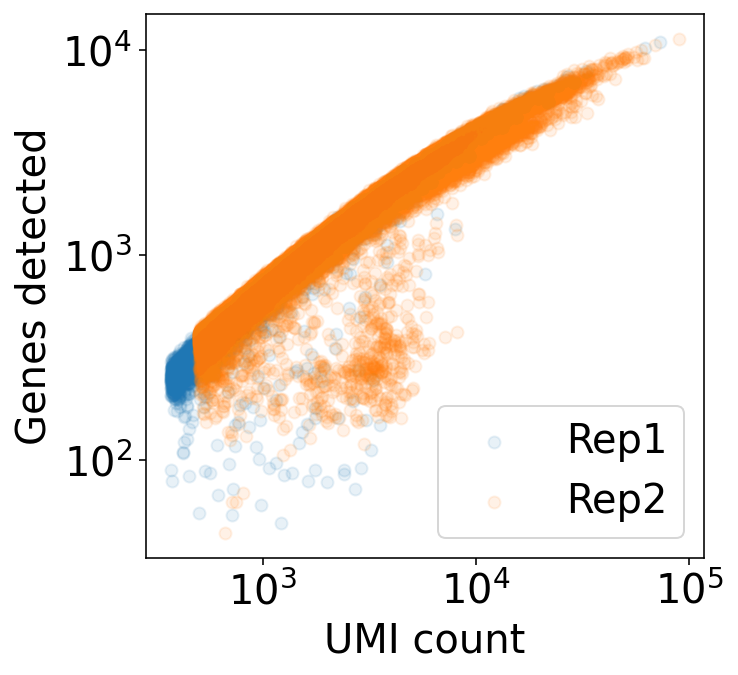

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

data = r1
label = "Rep1"
x = nd(data.X.sum(1))
y = nd((data.X>0).sum(1))

ax.scatter(x,y, label=label, alpha=0.1)

data = r2
label = "Rep2"
x = nd(data.X.sum(1))
y = nd((data.X>0).sum(1))

ax.scatter(x,y, label=label, alpha=0.1)

ax.set(**{
    "xlabel": "UMI count",
    "ylabel": "Genes detected",
    "xscale": "symlog",
    "yscale": "symlog"
})

ax.legend()

fig.show()

# Normalization

In [40]:
# replicate 1
r1.layers["PF"] = normalize(r1.layers["raw"], norm="l1")*r1.layers["raw"].sum(1).mean()
r1.layers["log1pPF"] = np.log1p(r1.layers["PF"])
r1.layers["PFlog1pPF"] = normalize(r1.layers["log1pPF"], norm="l1")*r1.layers["log1pPF"].sum(1).mean()


# replicate 2
r2.layers["PF"] = normalize(r2.layers["raw"], norm="l1")*r2.layers["raw"].sum(1).mean()
r2.layers["log1pPF"] = np.log1p(r2.layers["PF"])
r2.layers["PFlog1pPF"] = normalize(r2.layers["log1pPF"], norm="l1")*r2.layers["log1pPF"].sum(1).mean()



In [41]:
mgenes = df.columns.values

In [42]:
r1.var_names = r1.var["gene_name"].astype(str)
r2.var_names = r2.var["gene_name"].astype(str)

In [43]:
r1m = r1[:,r1.var["gene_name"].isin(mgenes)][:,mgenes].copy()
r2m = r2[:,r2.var["gene_name"].isin(mgenes)][:,mgenes].copy()

In [44]:
# replicate 1
r1m.layers["PFm"] = normalize(r1m.layers["raw"], norm="l1")*r1m.layers["raw"].sum(1).mean()
r1m.layers["log1pPFm"] = np.log1p(r1m.layers["PFm"])
r1m.layers["PFlog1pPFm"] = normalize(r1m.layers["log1pPFm"], norm="l1")*r1m.layers["log1pPFm"].sum(1).mean()


# replicate 2
r2m.layers["PFm"] = normalize(r2m.layers["raw"], norm="l1")*r2m.layers["raw"].sum(1).mean()
r2m.layers["log1pPFm"] = np.log1p(r2m.layers["PFm"])
r2m.layers["PFlog1pPFm"] = normalize(r2m.layers["log1pPFm"], norm="l1")*r2m.layers["log1pPFm"].sum(1).mean()

In [16]:
# r1.X = r1.layers["PFlog1pPF"].copy()
# r2.X = r2.layers["PFlog1pPF"].copy()
# sc.pp.highly_variable_genes(r1, layer="log1pPF")
# sc.pp.highly_variable_genes(r2, layer="log1pPF")
# # We perform PCA on just the highly variable genes
# sc.tl.pca(r1, svd_solver='arpack', n_comps=100, use_highly_variable=True)

# sc.pp.neighbors(r1, n_neighbors=50, use_rep="X_pca")

# sc.tl.leiden(r1, random_state=42)

# print(r1.obs["leiden"].nunique())
# print(r1.obs["leiden"].value_counts())

# # We perform PCA on just the highly variable genes
# sc.tl.pca(r2, svd_solver='arpack', n_comps=100, use_highly_variable=True)

# sc.pp.neighbors(r2, n_neighbors=50, use_rep="X_pca")

# sc.tl.leiden(r2, random_state=42)

# print(r2.obs["leiden"].nunique())
# print(r2.obs["leiden"].value_counts())

# sc.tl.rank_genes_groups(r1, 'leiden', method='t-test', corr_method="bonferroni", layer="PFlog1pPF")
# sc.tl.rank_genes_groups(r2, 'leiden', method='t-test', corr_method="bonferroni", layer="PFlog1pPF")

# # replicate 1
# pvals = rf.structured_to_unstructured(r1.uns["rank_genes_groups"]["pvals_adj"]).ravel()
# scores = rf.structured_to_unstructured(r1.uns["rank_genes_groups"]["scores"]).ravel()
# names = np.array([np.asarray(tuple(i)) for i in r1.uns["rank_genes_groups"]["names"]]).ravel()
# leiden = np.tile(np.arange(0, r1.obs.leiden.nunique()), r1.shape[1]).reshape(-1, r1.obs.leiden.nunique()).ravel()

# df1 = pd.DataFrame({"pvals": pvals, "scores": scores, "names": names, "leiden": leiden})

# # replicate 1
# pvals = rf.structured_to_unstructured(r2.uns["rank_genes_groups"]["pvals_adj"]).ravel()
# scores = rf.structured_to_unstructured(r2.uns["rank_genes_groups"]["scores"]).ravel()
# names = np.array([np.asarray(tuple(i)) for i in r2.uns["rank_genes_groups"]["names"]]).ravel()
# leiden = np.tile(np.arange(0, r2.obs.leiden.nunique()), r2.shape[1]).reshape(-1, r2.obs.leiden.nunique()).ravel()

# df2 = pd.DataFrame({"pvals": pvals, "scores": scores, "names": names, "leiden": leiden})

# df1.query("pvals < 1e-5 & scores > 10").groupby("leiden")["names"].apply(list)

In [45]:
CellAssign.setup_anndata(r1m, size_factor_key="size_factor")
CellAssign.setup_anndata(r2m, size_factor_key="size_factor")

In [59]:
r1m.X = r1m.layers["raw"].copy()
model = CellAssign(r1m, df.T)
model.train(max_epochs=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [15:06<00:00,  8.94s/it, loss=9.8, v_num=1] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [15:06<00:00,  9.06s/it, loss=9.8, v_num=1]


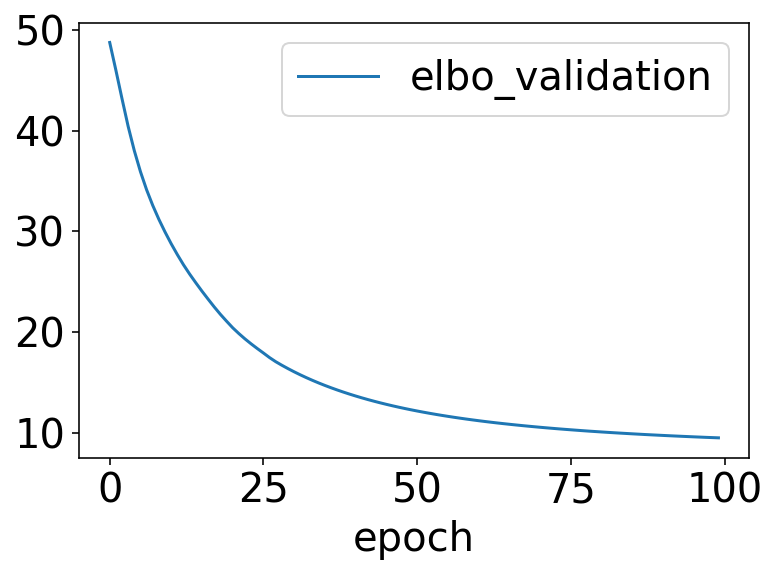

In [60]:
model.history["elbo_validation"].plot()


In [61]:
predictions = model.predict()

In [62]:
r1m.obs["celltype"] = predictions.idxmax(axis=1).values

In [63]:
r1m.obs["celltype"].value_counts()

Vasc3           9921
ExcitNeuron2    1891
Astro1           673
InhibNeuron1     325
Endo             194
OPCs              65
ExcitNeuron3      56
Vasc2             17
DivOPCs           16
COPs              10
Astro2             8
Macrophages        8
ChorPlex           7
NIPCs              6
RGL                6
InhibNeuron3       6
InhibNeuron2       5
Microglia          2
GranuleNB2         2
Vasc1              2
GranuleNB3         1
Name: celltype, dtype: int64

In [1]:
# from Joglekar et al. (https://doi.org/10.1038/s41467-020-20343-5)
# Astro1          300
# GranuleNB2      300
# RGL             300
# OPCs            300
# NIPCs           300
# Microglia       300
# InhibNeuron2    300
# InhibNeuron1    300
# Astro2          300
# GranuleNB3      300
# ExcitNeuron2    300
# ExcitNeuron1    300
# Endo            300
# DivOPCs         300
# ChorPlex        300
# GranuleNB1      150
# ExcitNeuron3    150
# Ependymal       150
# InhibNeuron3    150
# COPs            150
# Vasc1           150
# Vasc2           150
# Macrophages      70
# Vasc3            70

In [24]:
gmm = GaussianMixture(n_components=len(markers.keys()), random_state=12)
mtx = r1m.layers["log1pPFm"].A
labels = gmm.fit_predict(mtx)

In [25]:
means = pd.DataFrame(mtx, columns=r1m.var["gene_name"], index=pd.Index(labels, name="labels")).groupby("labels").mean()

In [26]:
means

gene_name,Aldoc,Apoe,Aqp1,Bhlhe22,C1ql1,Calb2,Ccna2,Cldn5,Cxcl14,Dcn,...,Riiad1,Rrm2,Slc32a1,Slc4a5,Sostdc1,Sp9,Sst,Tmem119,Top2a,Trem2
labels,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000365,0.000365,0.024868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.002124,0.109039,0.000000,0.000000,0.000000,0.226978,0.000000,0.000000,0.181768,0.000000,...,0.002124,0.002124,0.194152,0.001799,0.084313,0.333924,0.000000,0.000000,0.000000,0.000000
3,0.015726,0.417525,0.302018,0.085606,0.000000,0.006608,0.006608,0.013814,0.002273,0.000000,...,0.119638,0.000000,0.009891,0.106633,0.290672,0.000000,0.029799,0.032768,0.000000,0.022423
4,0.123014,0.143702,0.000000,0.325661,0.001156,0.000000,0.000000,0.121459,0.163989,0.000000,...,0.000000,0.000000,0.028085,0.000000,0.000000,0.077323,0.030381,0.017536,0.111413,0.000000
5,0.061346,0.091212,0.000000,0.000000,0.000000,0.000000,0.000000,0.136329,0.068787,0.000000,...,0.000000,0.000000,0.122616,0.000000,0.000000,0.000000,0.089928,0.000000,0.000000,0.000000
6,0.255598,0.000000,0.000000,0.000000,0.000000,0.203091,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.282479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.042151,0.222639,0.000000,0.035991,0.004261,0.072946,0.000000,0.000000,0.000000,0.000571,...,0.000000,0.000000,0.060650,0.000000,0.000829,0.000000,0.076908,0.000000,0.231941,0.000000
8,0.058458,0.178001,0.000000,0.044271,0.000000,0.109182,0.071022,0.123247,0.132405,0.000000,...,0.000000,0.000000,0.157459,0.000000,0.000000,0.004766,0.151145,0.000000,0.020167,0.150990


In [27]:
df

,Aldoc,Apoe,Aqp1,Bhlhe22,C1ql1,Calb2,Ccna2,Cldn5,Cxcl14,Dcn,...,Riiad1,Rrm2,Slc32a1,Slc4a5,Sostdc1,Sp9,Sst,Tmem119,Top2a,Trem2
Astro1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Astro2,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
COPs,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ChorPlex,0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
DivOPCs,0,0,0,0,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
Endo,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
Ependymal,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
ExcitNeuron1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ExcitNeuron2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ExcitNeuron3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
from sklearn.metrics import pairwise_distances

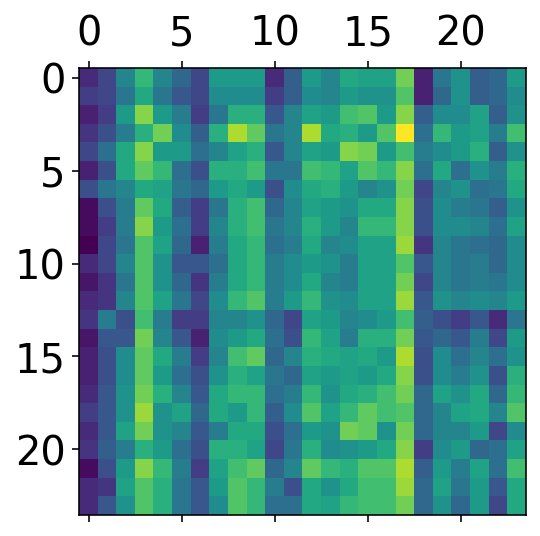

In [30]:
plt.matshow(pairwise_distances(df.values, means.values>0, metric="hamming"))